# Time Series analysis


I analyze the stocks data for time series analysis. 
Techniques like MA, AR, and ARIMA models will be used. 

In [7]:
import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

yfin.pdr_override()

# List of stock symbols
ticker = 'GOOGL'

# Set the date range for the historical data

# choose data over 2 years
start_date = '2015-1-1'
end_date = '2017-1-1'

# get the data with 1d interval 
price = pdr.get_data_yahoo(ticker, start_date, end_date,interval='1d')['Adj Close']
price.dropna(inplace=True)
# get log returns
returns = np.log(price).diff()

# we can drop the days with no prices because we consider th
returns.dropna(inplace=True)

# split the data into train and test
split = int(len(returns.values) * 0.90)

price_train = price.iloc[:split+1]
price_test = price.iloc[split:]
return_train = returns.iloc[:split]
return_test = returns.iloc[split:]
print(return_test.shape,return_train.shape,price_test.shape,price_train.shape,price.shape)




[*********************100%%**********************]  1 of 1 completed

(51,) (452,) (52,) (453,) (504,)


<Axes: title={'center': 'GOOGL Stock Price'}, xlabel='Date', ylabel='Price'>

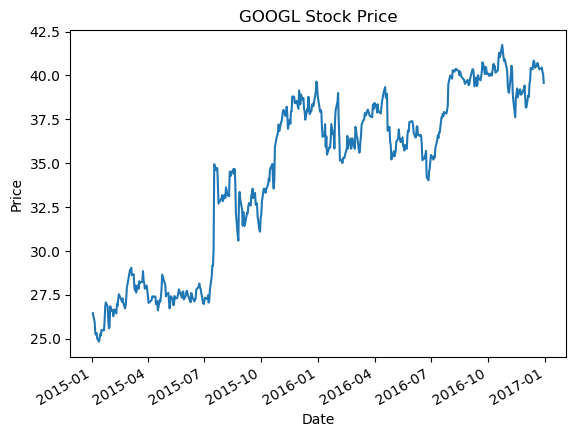

In [8]:
price.plot(title=f'{ticker} Stock Price',ylabel='Price',xlabel='Date')

<Axes: xlabel='Date'>

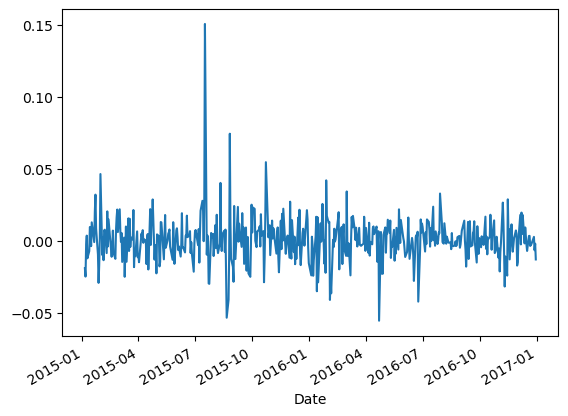

In [9]:
returns.plot()

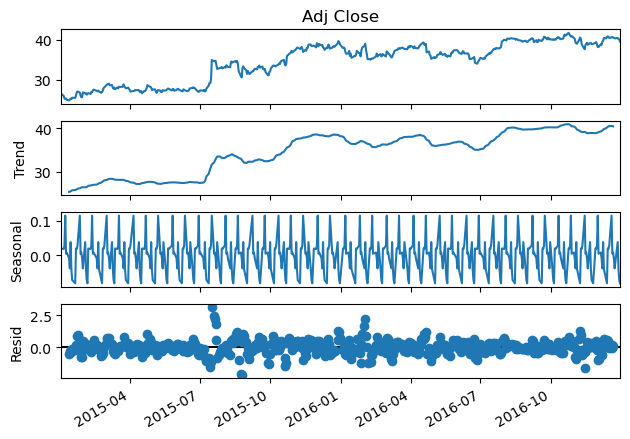

In [10]:
# Plot  the components of a time series by
# seasonal_decompose function from statsmodels
import matplotlib.pyplot as plt

seasonal_decompose(price, period=12).plot()
plt.gcf().autofmt_xdate()
plt.show()

## Stationarity 

Check the stationarity of returns using :

- Augmented Dickey-Fuller (ADF) Test
  - **Null Hypothesis (H₀)**: The time series has a unit root (i.e., it is **non-stationary**).
  - **Interpretation of p-value**: 
    - **Low p-value (≤ significance level, e.g., 0.05)**: Reject H₀, indicating the series is likely stationary.
    - **High p-value (> significance level)**: Fail to reject H₀, indicating the series is likely non-stationary.

- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
  - **Null Hypothesis (H₀)**: The time series is **stationary**.
  - **Interpretation of p-value**:
    - **Low p-value (≤ significance level, e.g., 0.05)**: Reject H₀, indicating the series is likely non-stationary.
    - **High p-value (> significance level)**: Fail to reject H₀, indicating the series is likely stationary.
  
-  Plots of the (partial) autocorrelation function (PACF/ACF)

In [11]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x):
    
    # run the test on x
    adf_test = adfuller(x, autolag="AIC")
    # create dataframe with adf_test results
    # fill first 4 indices
    indices = ["Test Statistic", "p-value", "No. of Lags Used", "No. of Observations Used"]
    results = pd.Series(adf_test[0:4], index=indices)
    
    # 4th item gives the dictionary containing critical values
    for key, value in adf_test[4].items():
        results[f"Critical Value {key}"] = value

    return results

test_results = adf_test(returns)

for column in test_results.keys():

    print(f"{column} : {test_results[column]}")

if test_results['p-value']<0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")


Test Statistic : -20.568004904365694
p-value : 0.0
No. of Lags Used : 0.0
No. of Observations Used : 502.0
Critical Value 1% : -3.4434437319767452
Critical Value 5% : -2.8673146875484368
Critical Value 10% : -2.569845688481135
Data is stationary


In [12]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

def kpss_test(x, h0_type="c"):    
    
    # Apply KPSS test
    kpss_test = kpss(x, regression=h0_type)
    
    # create dataframe with kpss_test results
    indices = ["Test Statistic", "p-value", "No. of Lags"]
    
    results = pd.Series(kpss_test[0:3], index=indices)

    # 3th item gives the dictionary containing critical values
    for key, value in kpss_test[3].items():
        results[f"Critical Value {key}"] = value

    return results

test_results = kpss_test(returns)

for column in test_results.keys():

    print(f"{column} : {test_results[column]}")

if test_results['p-value']>0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")


Test Statistic : 0.06428403968744108
p-value : 0.1
No. of Lags : 5.0
Critical Value 10% : 0.347
Critical Value 5% : 0.463
Critical Value 2.5% : 0.574
Critical Value 1% : 0.739
Data is stationary


## ACF and PCF

Auto-correlation functions (ACF) show the correlation between the same series with different lags. With h being the lag:

$ρ(h) = \frac{Cov(X_t , X_{t−h} )}{Var(X_t )}$

The coefficients help in deciding the q in MA(q) models.

Partial ACF (PACF) gives information on correlation between current value of a time series
and its lagged values controlling for the other correlations.

$ρ(h) = \frac{Cov(X_t ,X_{t−h} |X_{t−1} ,X_{t−2} ...X_{t−h−1})}{
\sqrt{Var(X_t |X_{t−1} ,X_{t−2} ,...,X_{t−h−1} )Var(X_{t−h} |X_{t−1} ,X_{t−2} ,...,X_{t−h−1} )}}$

The coefficients help in deciding the p in AR(p) models.


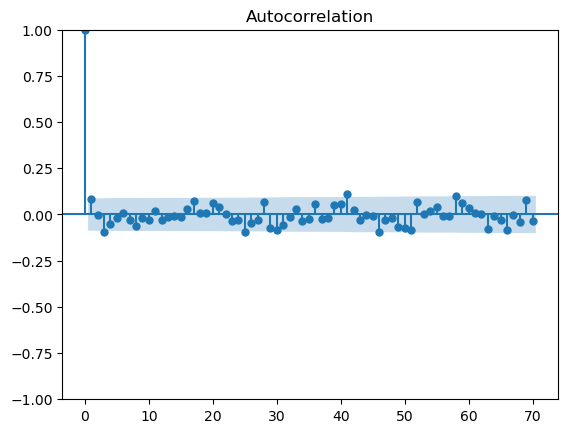

In [13]:
sm.graphics.tsa.plot_acf(returns,lags=70)
plt.show()

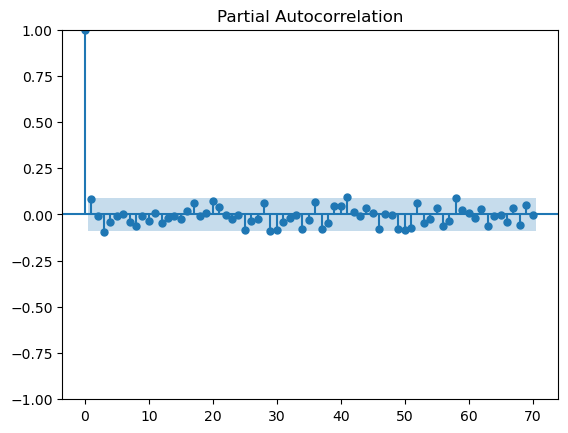

In [14]:
sm.graphics.tsa.plot_pacf(returns,lags=70)
plt.show()

Both ACF and PACF show that the returns are stationary and do not have a correlation with the lagged values.

## Time Series modeling

### Moving Average (MA)

Moving average can be considered as smoothing model as it tends to take into account the lag
values of residual.

For $\alpha \ne 0$, MA(q) can be written as:

$X_t = \epsilon_t + \alpha_1 \epsilon_{t−1} + \alpha_2 \epsilon_{t−2} ... + \alpha_q \epsilon_{t−q}$


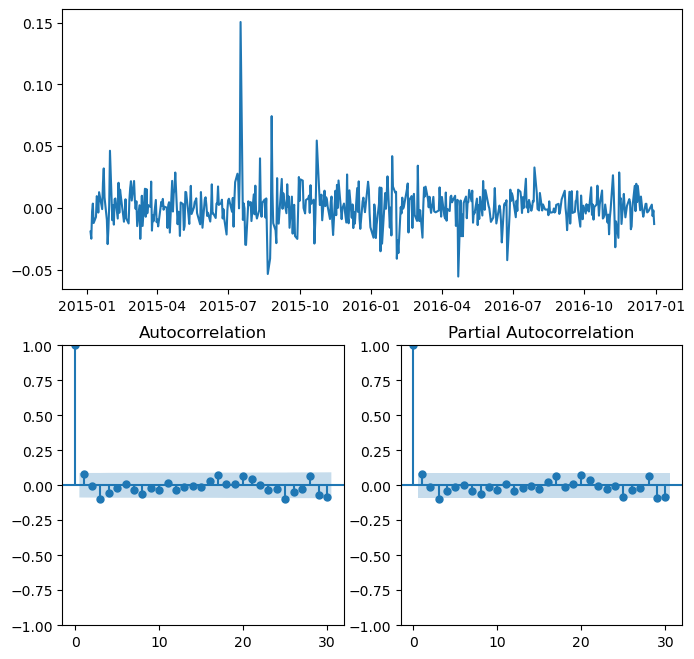

In [15]:

def ts_plots(data,lags):
    mosaic = """
    AA
    BC
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.subplot_mosaic(mosaic)
    ax['A'].plot(data)
    sm.graphics.tsa.plot_acf(returns.dropna(),ax=ax['B'],lags=lags)
    sm.graphics.tsa.plot_pacf(returns.dropna(),ax=ax['C'],lags=lags)
    
    fig.subplots_adjust()

ts_plots(returns,lags=30)
plt.show()

No Peak at in ACF, we choose them order for MA i.e. MA(0) Model

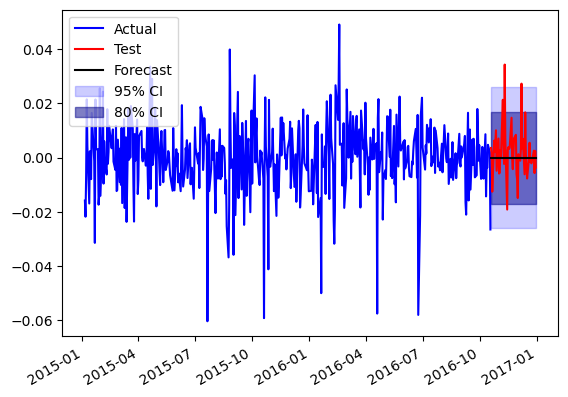

In [38]:
from statsmodels.tsa.arima.model import ARIMA

modelMA = ARIMA(return_train, order=(0, 0, 0)).fit()

forecast = modelMA.get_forecast(steps=len(return_test))

conf_int95 = forecast.conf_int(alpha=0.05)
conf_int80 = forecast.conf_int(alpha=0.2)


fig,ax = plt.subplots()
ax.plot(return_train.index,return_train.values,color='b',label='Actual')
ax.plot(return_test.index,return_test.values,color='r',label='Test')
ax.plot(return_test.index,forecast.predicted_mean,color='k',label='Forecast')
ax.fill_between(return_test.index,conf_int95['lower Adj Close'],conf_int95['upper Adj Close'],alpha=0.2,color='b',label='95% CI')
ax.fill_between(return_test.index,conf_int80['lower Adj Close'],conf_int80['upper Adj Close'],alpha=0.5,color='darkblue',label='80% CI')

ax.legend(loc=2)
plt.gcf().autofmt_xdate()


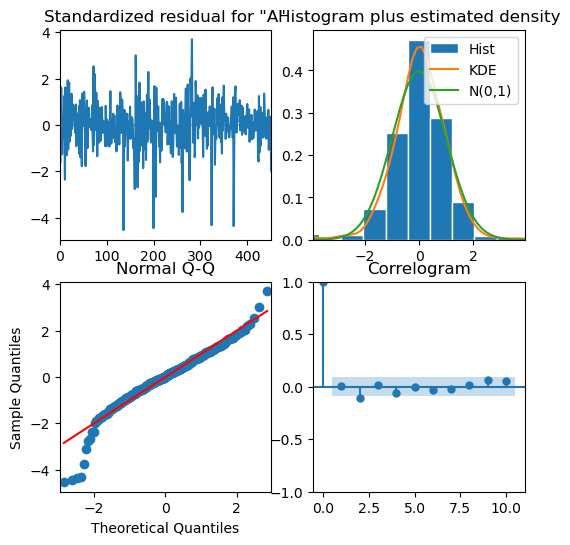

In [75]:
# inspect residuals
modelMA.plot_diagnostics(figsize=(6,6))
plt.show()

Residuals are white noise therefore, good fit

Transform back to prices

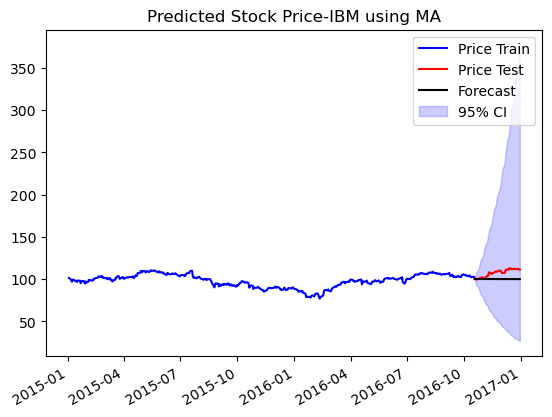

In [73]:
# use 95% confidence interval from above to return price forcasts and confidence intervals
# pf=[]
# pf.append(price_train[-1])
# confd = []
# confd.append(price_train[-1])
# confu = []
# confu.append(price_train[-1])

cumulative_log_returns = forecast.predicted_mean.cumsum()
# Step 2: Exponentiate to get back to price levels
price_reconstructed = np.exp(cumulative_log_returns)

pf = price_train[-1] * price_reconstructed


cumulative_log_returns = conf_int95['lower Adj Close'].cumsum()
price_reconstructed = np.exp(cumulative_log_returns)
confd = price_train[-1] * price_reconstructed

cumulative_log_returns = conf_int95['upper Adj Close'].cumsum()
price_reconstructed = np.exp(cumulative_log_returns)
confu = price_train[-1] * price_reconstructed

fig,ax = plt.subplots()
ax.plot(price_train.index,price_train.values,color='b',label='Price Train')
ax.plot(price_test.index,price_test.values,color='r',label='Price Test')
ax.plot(price_test.index[1:],pf,color='k',label='Forecast')
ax.fill_between(price_test.index[1:],confd,confu,alpha=0.2,color='b',label='95% CI')
ax.set_title(f'Predicted Stock Price-{ticker} using MA')
ax.legend()
plt.gcf().autofmt_xdate()



In [77]:
sm.stats.durbin_watson(modelMA.resid.values)


1.9819498421458848

Short-term moving average tends to more reactive to daily activity and long MA captures the global trend, But still the model is not able to capture the trends

### Autoregressive Model

Idea is the current value is regressed over its own lag
values in this model. Forcast the current value of time series $X_{t}$:


$X_t = c + \alpha_1 X_{t−1} + \alpha_2 X_{t−2} ... + \alpha_p X_{t−p} + \epsilon_t$



We see no peak beyond 0 so using MA(0)

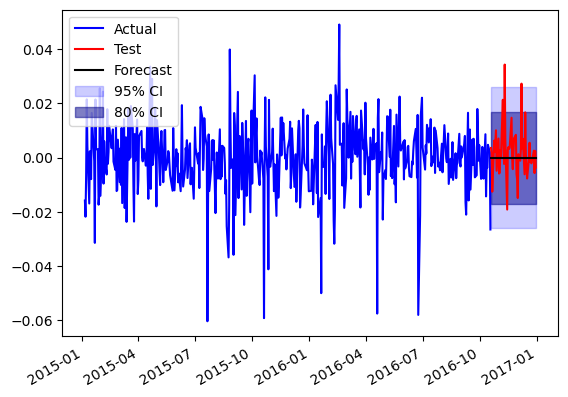

In [75]:
from statsmodels.tsa.arima.model import ARIMA

modelMA = ARIMA(return_train, order=(0, 0, 0)).fit()

forecast = modelMA.get_forecast(steps=len(return_test))

conf_int95 = forecast.conf_int(alpha=0.05)
conf_int80 = forecast.conf_int(alpha=0.2)


fig,ax = plt.subplots()
ax.plot(return_train.index,return_train.values,color='b',label='Actual')
ax.plot(return_test.index,return_test.values,color='r',label='Test')
ax.plot(return_test.index,forecast.predicted_mean,color='k',label='Forecast')
ax.fill_between(return_test.index,conf_int95['lower Adj Close'],conf_int95['upper Adj Close'],alpha=0.2,color='b',label='95% CI')
ax.fill_between(return_test.index,conf_int80['lower Adj Close'],conf_int80['upper Adj Close'],alpha=0.5,color='darkblue',label='80% CI')

ax.legend(loc=2)
plt.gcf().autofmt_xdate()


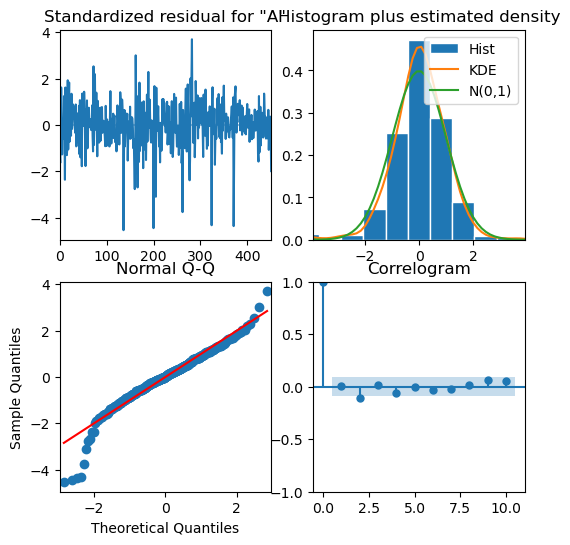

In [32]:
# inspect residuals
modelMA.plot_diagnostics(figsize=(6,6))
plt.show()

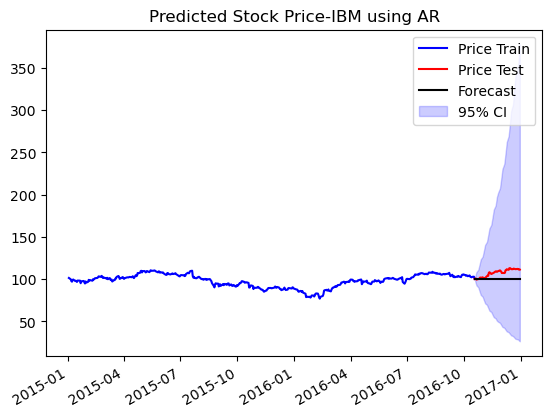

In [77]:
# use 95% confidence interval from above to return price forcasts and confidence intervals
# pf=[]
# pf.append(price_train[-1])
# confd = []
# confd.append(price_train[-1])
# confu = []
# confu.append(price_train[-1])

# for ret,dn,up in zip(forecast.predicted_mean.values,conf_int95['lower Adj Close'].values,conf_int95['upper Adj Close'].values):
#     # Calculate cumulative log return
#     cumulative_log_return = np.log(1 + np.array(ret)).sum()
#     # Calculate new price
#     new_price = price_train[-1] * np.exp(cumulative_log_return)

#     # up and down
#     cumulative_log_return = np.log(1 + np.array(up)).sum()
#     confu.append(price_train[-1] * np.exp(cumulative_log_return))

#     cumulative_log_return = np.log(1 + np.array(dn)).sum()
#     confd.append(price_train[-1] * np.exp(cumulative_log_return))

#     pf.append(new_price)

pf = price_train[-1] * np.exp(forecast.predicted_mean)

cumulative_log_returns = conf_int95['lower Adj Close'].cumsum()
price_reconstructed = np.exp(cumulative_log_returns)
confd = price_train[-1] * price_reconstructed

cumulative_log_returns = conf_int95['upper Adj Close'].cumsum()
price_reconstructed = np.exp(cumulative_log_returns)
confu = price_train[-1] * price_reconstructed

fig,ax = plt.subplots()
ax.plot(price_train.index,price_train.values,color='b',label='Price Train')
ax.plot(price_test.index,price_test.values,color='r',label='Price Test')
ax.plot(price_test.index[1:],pf,color='k',label='Forecast')
ax.fill_between(price_test.index[1:],confd,confu,alpha=0.2,color='b',label='95% CI')
ax.set_title(f'Predicted Stock Price-{ticker} using AR')
ax.legend()
plt.gcf().autofmt_xdate()



AR(0) model does a similar job to MA(0) at predicting the stock trend but still is not able to predict it to good affect.
Both models are similar to trivial model with last price forcasting.

### ARIMA Models

ARIMA models are a combination of three key components: AutoRegressive (AR), Integrated (I), and Moving Average (MA). The advantage of intergration parameter is that is non-stationary data is used it can make it stationary by defining the integration parameter. 

Three parameters are to be defined p (dicussed above for AR), q (dicussed for MA) and d (control for level difference). d=1 is makes the model ARMA which is a limiting case of ARIMA (p,1,q) models but is also a good model given by:

$Xt = \alpha_1 dX_{t−1} + \alpha_2 dX_{t−2} ... + \alpha_p dX_{t−p} + \epsilon_t + \beta_1 d\epsilon_{t−1} + \beta_2 d\epsilon_{t−2} ... + \beta_q d\epsilon_{t−q}$

Pros
 - ARIMA allows us to work with raw data without considering if it is
stationary.
 - It performs well with high-frequent data.
It is less sensitive to the fluctuation in the data compared to other models.

Cons
 - ARIMA might fail in capturing seasonality.
 - It work better with a long series and short-term (daily, hourly) data.
 - As no automatic updating occurs in ARIMA, no structural break during the analysis period should be observed.
 - Having no adjustment in the ARIMA process leads to instability.


Choosing the parameters from for the ARIMA model. I choose the range 0-10 for the p and q and 0-3 for d.
Selection of the parameters for the model is made using Akaike Information Criterion (AIC). The parameters resulting in minimum value of AIC are selected. 

$AIC=2k−2ln(L)$

Where:
 - AIC is the Akaike Information Criterion.
 - k is the number of parameters in the model.
 - ln(L) is the natural logarithm of the likelihood of the model.




In [85]:
stat_test = adfuller(returns.dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The returns are stationary")
else:
    print("The returns are not stationary")

The test statistic and p-value of ADF test are (-17.63822113316783, 3.7698587951151705e-30)
The returns are stationary


Since returns are stationary so set d=1

In [16]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


model = auto_arima(price_train, start_p=0, start_q=0,
            test='adf',       
            max_p=12, max_q=12,             
            d=1,           
            seasonal=True,  
            start_P=0, 
            D=1, 
            trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=707.982, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=708.185, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=708.212, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=707.671, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=710.185, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.234 seconds


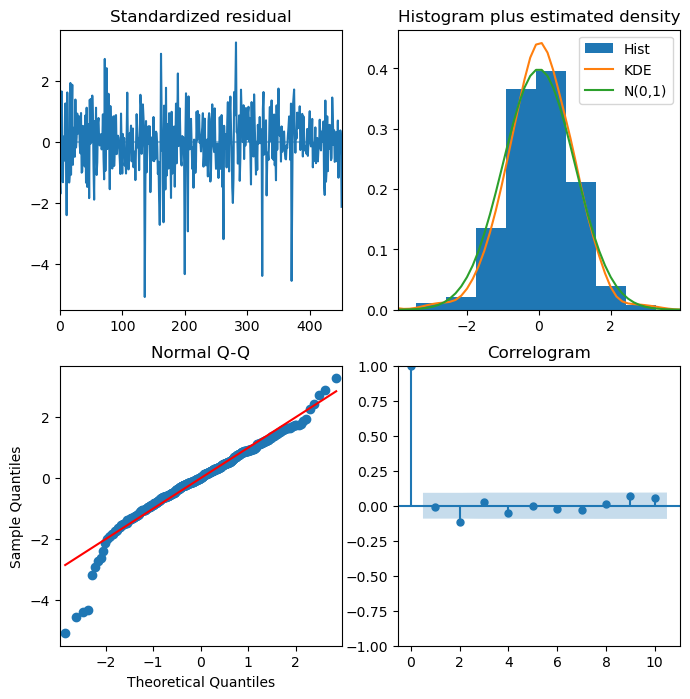

In [79]:
# inspect residuals
model.plot_diagnostics(figsize=(8,8))
plt.show()

In [80]:
y_forec95, conf_int95  = model.predict(len(price_test),return_conf_int=True,alpha=0.05)
y_forec80, conf_int80  = model.predict(len(price_test),return_conf_int=True,alpha=0.2)


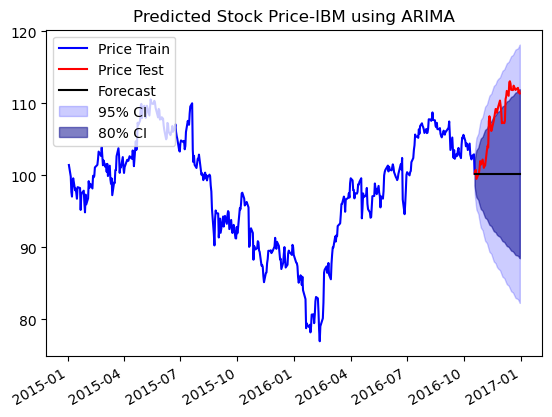

In [81]:

fig,ax = plt.subplots()
ax.plot(price_train.index,price_train.values,color='b',label='Price Train')
ax.plot(price_test.index,price_test.values,color='r',label='Price Test')
ax.plot(price_test.index,y_forec95,color='k',label='Forecast')
ax.fill_between(price_test.index,conf_int95[:,0],conf_int95[:,1],alpha=0.2,color='b',label='95% CI')
ax.fill_between(price_test.index,conf_int80[:,0],conf_int80[:,1],alpha=0.5,color='darkblue',label='80% CI')
ax.set_title(f'Predicted Stock Price-{ticker} using ARIMA')
ax.legend(loc=2)
plt.gcf().autofmt_xdate()

The ARIMA model is able to get capture the trend of the price movement and does a better job at predicting prices. The prices lie within the 80% confidence interval.

## Prophet 

In [5]:
from prophet import Prophet

alldat = price.to_frame().reset_index()
alldat.rename(columns={'Date':'ds','Adj Close':'y'},inplace=True)

# # Specify the split date
split_date = pd.to_datetime('2020-10-01')

# Split the DataFrame into two based on the split date
train_df = alldat[alldat['ds'] < split_date]
test_df = alldat[alldat['ds'] >= split_date]



m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(train_df)


00:18:22 - cmdstanpy - INFO - Chain [1] start processing
00:18:23 - cmdstanpy - INFO - Chain [1] done processing


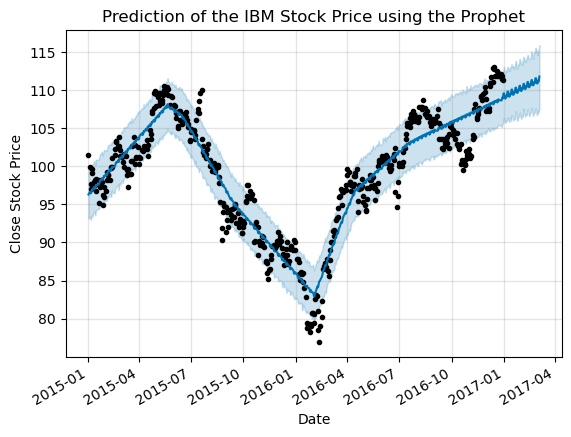

In [6]:
future = m.make_future_dataframe(periods=64) #we need to specify the number of days in future

fig,ax = plt.subplots()
prediction = m.predict(future)
m.plot(prediction,ax=ax)
ax.set_title(f"Prediction of the {ticker} Stock Price using the Prophet")
ax.set_xlabel("Date")
ax.set_ylabel("Close Stock Price")
ax.plot(test_df['ds'],test_df['y'],color='r')
plt.gcf().autofmt_xdate()
plt.show()

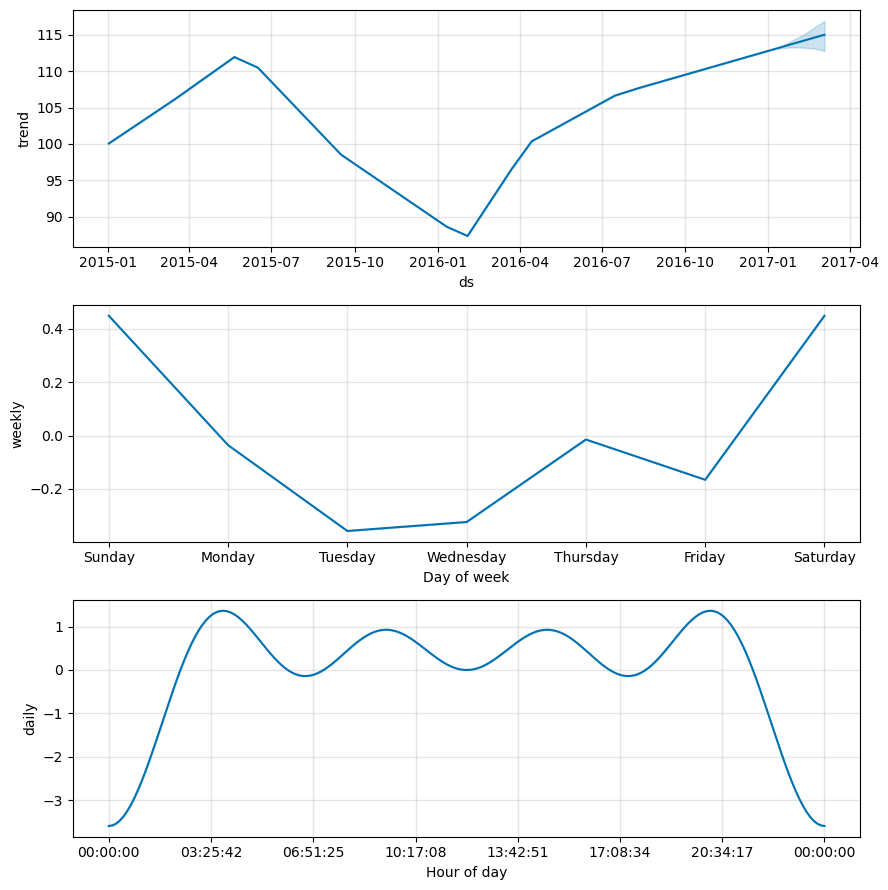

In [93]:
m.plot_components(prediction)
plt.show()

Prophet seems to do a very good job for predicting the stock future movements out of the box

[*********************100%%**********************]  1 of 1 completed


ARIMA(0, 0, 0) - AIC:5579.25
ARIMA(0, 0, 1) - AIC:4493.44
ARIMA(0, 0, 2) - AIC:3742.74


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 3) - AIC:3264.49


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 4) - AIC:2908.27
ARIMA(0, 1, 0) - AIC:1740.90
ARIMA(0, 1, 1) - AIC:1742.46
ARIMA(0, 1, 2) - AIC:1740.93
ARIMA(0, 1, 3) - AIC:1735.84
ARIMA(0, 1, 4) - AIC:1737.03
ARIMA(1, 0, 0) - AIC:1749.76
ARIMA(1, 0, 1) - AIC:1751.40
ARIMA(1, 0, 2) - AIC:1750.12
ARIMA(1, 0, 3) - AIC:1744.64
ARIMA(1, 0, 4) - AIC:1746.00
ARIMA(1, 1, 0) - AIC:1742.52
ARIMA(1, 1, 1) - AIC:1740.74
ARIMA(1, 1, 2) - AIC:1737.10
ARIMA(1, 1, 3) - AIC:1737.08
ARIMA(1, 1, 4) - AIC:1738.98
ARIMA(2, 0, 0) - AIC:1751.44


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1) - AIC:1749.46


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) - AIC:1746.24
ARIMA(2, 0, 3) - AIC:1746.00
ARIMA(2, 0, 4) - AIC:1748.00
ARIMA(2, 1, 0) - AIC:1740.91


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) - AIC:1736.44
ARIMA(2, 1, 2) - AIC:1732.39
ARIMA(2, 1, 3) - AIC:1734.30
ARIMA(2, 1, 4) - AIC:1737.92
ARIMA(3, 0, 0) - AIC:1750.12
ARIMA(3, 0, 1) - AIC:1745.59


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) - AIC:1741.41
ARIMA(3, 0, 3) - AIC:1743.36
ARIMA(3, 0, 4) - AIC:1749.93
ARIMA(3, 1, 0) - AIC:1736.05
ARIMA(3, 1, 1) - AIC:1736.46
ARIMA(3, 1, 2) - AIC:1734.31


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) - AIC:1736.06


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4) - AIC:1736.84
ARIMA(4, 0, 0) - AIC:1744.85
ARIMA(4, 0, 1) - AIC:1745.36


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 2) - AIC:1743.45


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 0, 3) - AIC:1745.27


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 4) - AIC:1746.75
ARIMA(4, 1, 0) - AIC:1736.35
ARIMA(4, 1, 1) - AIC:1738.22
ARIMA(4, 1, 2) - AIC:1735.75


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 3) - AIC:1736.27


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 4) - AIC:1738.36
Best ARIMA order: (2, 1, 2) with AIC: 1732.39
Mean Squared Error: 31.78


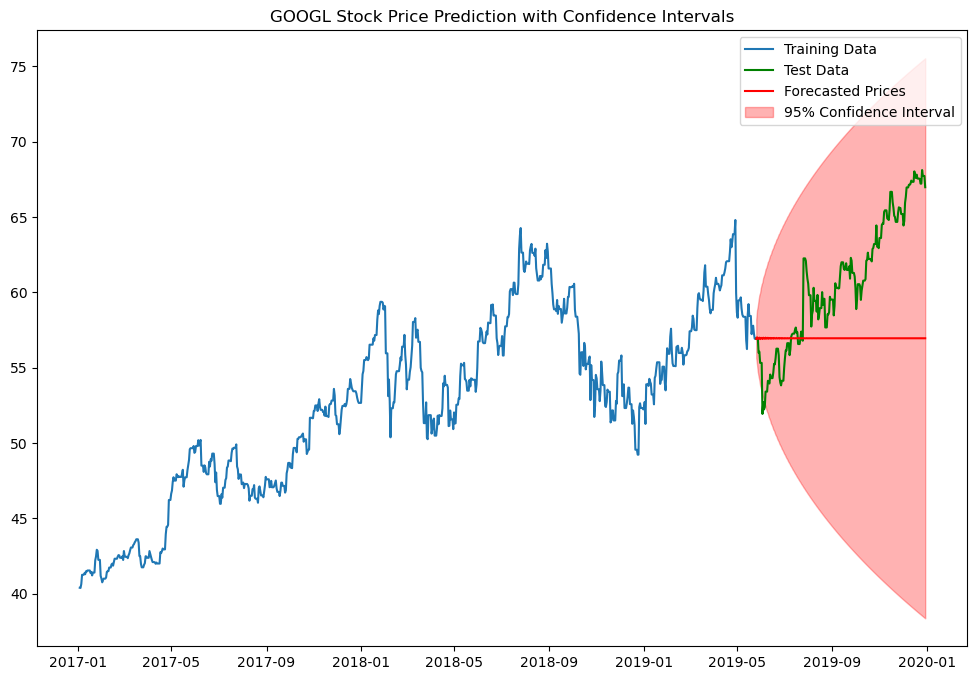

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Fetch historical data
ticker = 'GOOGL'
start_date = '2017-01-01'
end_date = '2019-12-31'
data = yf.download(ticker, start=start_date, end=end_date, interval='1D')
prices = data['Close']

# Prepare data
prices.index = pd.DatetimeIndex(prices.index)
prices = prices.asfreq('D')
if prices.isna().any():
    prices = prices.ffill()

# Split the data into training and test sets
train_size = int(len(prices) * 0.8)  # Use 80% of data for training
train_prices, test_prices = prices[:train_size], prices[train_size:]


# Grid search for best ARIMA(p, d, q) using AIC
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

best_aic = np.inf  # Initialize best AIC to infinity
best_order = None
best_model = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_prices, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
                print(f'ARIMA{p,d,q} - AIC:{aic:.2f}')
            except Exception as e:
                print(f'Error with ARIMA{p,d,q}: {e}')
                continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic:.2f}')
# Forecast future values on the test set
forecast_result = best_model.get_forecast(steps=len(test_prices))
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_prices, forecast_mean)
print(f'Mean Squared Error: {mse:.2f}')

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_prices.index, train_prices, label='Training Data')
plt.plot(test_prices.index, test_prices, label='Test Data', color='green')
plt.plot(test_prices.index, forecast_mean, color='red', label='Forecasted Prices')

# Plot confidence intervals
plt.fill_between(test_prices.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='red', alpha=0.3, label='95% Confidence Interval')

plt.title(f'{ticker} Stock Price Prediction with Confidence Intervals')
plt.legend()
plt.show()




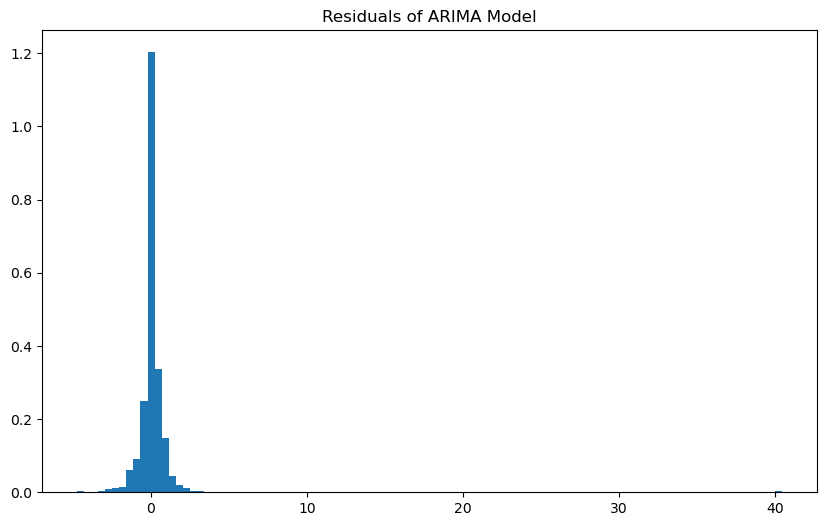

In [5]:
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.hist(residuals,bins=100,density=True)
plt.title('Residuals of ARIMA Model')
plt.show()

In [104]:
import statsmodels.api as sm
sm.graphics.tsa.tsa_results(model_fit).plot_acf()
sm.graphics.tsa.tsa_results(model_fit).plot_pacf()

AttributeError: module 'statsmodels.graphics.tsaplots' has no attribute 'tsa_results'